In [9]:
import pandas as pd
from geopy.distance import geodesic
from gurobipy import Model, GRB, quicksum
from collections import defaultdict, OrderedDict
import numpy as np
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import sys
import math

# Get the absolute path of the parent directory and insert into sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

from Prepare_wind_farm_list import wind_farm_list

# Remove Sofia (Teesside B) as it is duplicated in the wind_farm_list
for wf in wind_farm_list:
    if wf["name"] == "Sofia (Teesside B)":
        wind_farm_list.remove(wf)
        break 

In [10]:
# Define the ports dictionary with ticker keys, names, and coordinates
ports = {
    'NOBGO': {'name': 'Port of Bergen',    'lat': 60.39, 'lon': 5.32},
    'GBABD': {'name': 'Port of Aberdeen',  'lat': 57.14, 'lon': -2.08},
    'NOSTV': {'name': 'Port of Stavanger', 'lat': 58.98, 'lon': 5.73},
    'GBHUL': {'name': 'Port of Hull',      'lat': 53.74, 'lon': -0.28},
    'NOKRS': {'name': 'Port of Kristiansand', 'lat': 58.15, 'lon': 8.01},
    'GBTYN': {'name': 'Port of Newcastle', 'lat': 55.00, 'lon': -1.48},
    'NLRTM': {'name': 'Port of Rotterdam', 'lat': 51.94, 'lon': 4.14},
}

vessel_info = [
    {
        'vessel_id': 1,
        'name': '1',
        'start': ports['NOBGO'],
        'mandatory': [
            ports['NOSTV'],
            ports['NOKRS'],
            ports['NLRTM'],
            ports['GBHUL'],
            ports['GBTYN'],
            ports['GBABD']
        ],
        'end': ports['NOBGO'],
        'CS': 7,    
        'FC': 0.2,  
        'CLO': 100.0,  
        'Q': 1000.0,  
        'R': 2,
        'speed': 15,           
        'charging_rate': 2,     
        'time_penalty': 0
    },
    {
        'vessel_id': 2,
        'name': '2',
        'start': ports['NOBGO'],
        'mandatory': [
            ports['NOSTV'],
            ports['NOKRS'],
            ports['GBHUL'],
            ports['GBTYN']
        ],
        'end': ports['NOSTV'],
        'CS': 11,
        'FC': 0.23,
        'CLO': 80.0,
        'Q': 1000.0,
        'R': 3,
        'speed': 15,            
        'charging_rate': 2,     
        'time_penalty': 0
    },
    {
        'vessel_id': 3,
        'name': '3',
        'start': ports['NOBGO'],
        'mandatory': [
            ports['NOSTV']
        ],
        'end': ports['NLRTM'],
        'CS': 12,
        'FC': 0.25,
        'CLO': 110.0,
        'Q': 1000.0,
        'R': 2,
        'speed': 15,
        'charging_rate': 2,
        'time_penalty': 0
    }
]

# Helper function to find the ticker given a port reference
def get_ticker_from_port(port):
    for ticker, port_info in ports.items():
        if port_info == port:
            return ticker
    return "Unknown"

# Update the vessel names to use the port tickers in the route
for i, vessel in enumerate(vessel_info, start=1):
    route = []
    # Use the ticker of the start port
    route.append(get_ticker_from_port(vessel['start']))
    # Append the tickers for all mandatory ports
    route.extend(get_ticker_from_port(p) for p in vessel['mandatory'])
    # Finally, append the ticker for the end port
    route.append(get_ticker_from_port(vessel['end']))
    
    vessel['name'] = f"Vessel {i}: " + " -> ".join(route)

S_max = 3 # maximum number of offshore charging stations that can be built
full_charge_mode = 0  # 1 for full charge at each node, 0 for optimizing charging strategy

CS_v  = {}   # Sailing cost per nm
FC_v  = {}   # Energy consumption per nm
CLO_v = {}   # Lost opportunity cost per unit battery capacity
Q_v   = {}   # Maximum battery capacity possible (cargo space)
R_v   = {}   # Maximum number of stops at wind farms allowed
speed_v = {}           # Sailing speed in nm/hr
charging_rate_v = {}   # Charging speed in energy units/hr
time_penalty_v = {}    # Time penalty cost per hour
for vdata in vessel_info:
    v = vdata['vessel_id']
    CS_v[v] = vdata['CS']
    FC_v[v] = vdata['FC']
    CLO_v[v] = vdata['CLO']
    Q_v[v] = vdata['Q']
    R_v[v] = vdata['R']
    speed_v[v] = vdata['speed']
    charging_rate_v[v] = vdata['charging_rate']
    time_penalty_v[v] = vdata['time_penalty']

# Create set of nodes
all_nodes = []
for vdata in vessel_info:
    v_id = vdata['vessel_id']
    # Start node
    all_nodes.append({
        'vessel_id': v_id,
        'name':      vdata['start']['name'],
        'lat':       vdata['start']['lat'],
        'lon':       vdata['start']['lon'],
        'type':      f"start_v{v_id}"
    })
    # Mandatory nodes
    for mand_port in vdata['mandatory']:
        all_nodes.append({
            'vessel_id': v_id,
            'name':      mand_port['name'],
            'lat':       mand_port['lat'],
            'lon':       mand_port['lon'],
            'type':      f"mandatory_v{v_id}"
        })
    # End node
    all_nodes.append({
        'vessel_id': v_id,
        'name':      vdata['end']['name'],
        'lat':       vdata['end']['lat'],
        'lon':       vdata['end']['lon'],
        'type':      f"end_v{v_id}"
    })
# Add wind farms
for wf in wind_farm_list:
    all_nodes.append({
        'vessel_id': None,
        'name':      wf['name'],
        'lat':       wf['lat'],
        'lon':       wf['lon'],
        'type':      'wind_farm'
    })

# Deduplicate nodes
dedup_dict = OrderedDict()
for nd in all_nodes:
    key = (nd['name'], nd['lat'], nd['lon'], nd['type'])
    if key not in dedup_dict:
        dedup_dict[key] = nd

nodes_dict = {}
for i, nd in enumerate(dedup_dict.values()):
    nodes_dict[i] = nd

node_key_to_id = {}
for node_id, node in nodes_dict.items():
    key = (node['name'], node['lat'], node['lon'], node['type'])
    node_key_to_id[key] = node_id

N = list(nodes_dict.keys())

# Vessel sets
V = []
vessel_nodes = {}
for vdata in vessel_info:
    v_id = vdata['vessel_id']
    V.append(v_id)
    start_key = (vdata['start']['name'], vdata['start']['lat'], vdata['start']['lon'], f"start_v{v_id}")
    end_key   = (vdata['end']['name'], vdata['end']['lat'], vdata['end']['lon'], f"end_v{v_id}")
    start_idx = node_key_to_id.get(start_key)
    end_idx = node_key_to_id.get(end_key)
    mand_idxs = []
    for mand_port in vdata['mandatory']:
        key = (mand_port['name'], mand_port['lat'], mand_port['lon'], f"mandatory_v{v_id}")
        idx = node_key_to_id.get(key)
        if idx is not None:
            mand_idxs.append(idx)
        else:
            print(f"Warning: could not find mandatory node for {mand_port}")
    vessel_nodes[v_id] = {
        'start': start_idx,
        'mandatory': mand_idxs,
        'end': end_idx
    }

# Identify wind farm nodes
wind_farms = [i for i in N if nodes_dict[i]['type'] == 'wind_farm']

# Arc sets per vessel
A_v = {}
vessel_map = {vdata['vessel_id']: vdata for vdata in vessel_info}
for vdata in vessel_info:
    v = vdata['vessel_id']
    start_idx = vessel_nodes[v]['start']
    end_idx = vessel_nodes[v]['end']
    itinerary = [start_idx] + vessel_nodes[v]['mandatory'] + [end_idx]
    wind_farm_indices = wind_farms  # all wind farms are available
    arcs_for_v = []
    # For each segment between consecutive mandatory stops:
    for seg in range(len(itinerary) - 1):
        current_stop = itinerary[seg]
        next_stop = itinerary[seg + 1]
        possible_origins = [current_stop] + wind_farm_indices  # Origins: current_stop and all wind farms
        possible_destinations = wind_farm_indices + [next_stop]  # Destinations: all wind farms and next_stop
        for o in possible_origins:
            for d in possible_destinations:
                if o != d:
                    arcs_for_v.append((o, d))
    A_v[v] = list(set(arcs_for_v))

# Distance matrix 
D_ij = {}
for i in N:
    for j in N:
        if i != j:
            lat_i, lon_i = nodes_dict[i]['lat'], nodes_dict[i]['lon']
            lat_j, lon_j = nodes_dict[j]['lat'], nodes_dict[j]['lon']
            D_ij[(i, j)] = geodesic((lat_i, lon_i), (lat_j, lon_j)).nm

# Energy cost
CB_i = {}
for i in N:
    if nodes_dict[i]['type'] == 'wind_farm':
        CB_i[i] = 10
    else:
        CB_i[i] = 5

In [11]:
model = Model("Multiple_Vessels_Ports_and_Stations")

z = {} # Decision variable: z[(v,i,j)] = 1 if vessel v travels from node i to j
for v in V:
    for (i, j) in A_v[v]:
        z[(v, i, j)] = model.addVar(vtype=GRB.BINARY, name=f"z_v{v}_{i}_{j}")

y = {} # Decision variable: y[i] = 1 if a wind farm station is built at node i
for i in N:
    if nodes_dict[i]['type'] == 'wind_farm':
        y[i] = model.addVar(vtype=GRB.BINARY, name=f"y_{i}")
    else:
        y[i] = model.addVar(vtype=GRB.BINARY, lb=0, ub=0, name=f"y_{i}")

q_v = {} # Installed Battery Capacity: q_v[v] for vessel v
for v in V:
    q_v[v] = model.addVar(lb=0, ub=Q_v[v], vtype=GRB.CONTINUOUS, name=f"q_v{v}")

candidate_nodes = {} # Candidate nodes for each vessel
for v in V:
    cand = []
    cand.append(vessel_nodes[v]['start'])
    cand.extend(vessel_nodes[v]['mandatory'])
    cand.append(vessel_nodes[v]['end'])
    for wf in wind_farms:
        if wf not in cand:
            cand.append(wf)
    candidate_nodes[v] = list(set(cand)) # Remove duplicates

battery = {} # Battery variables
charge = {} # Charge variables
for v in V:
    for i in candidate_nodes[v]:
        battery[(v, i)] = model.addVar(lb=0, name=f"battery_v{v}_{i}")
        charge[(v, i)] = model.addVar(lb=0, name=f"charge_v{v}_{i}")

# Objective Function
obj = 0
for v in V: # Sailing cost
    for (i, j) in A_v[v]:
        obj += CS_v[v] * D_ij[(i, j)] * z[(v, i, j)]


for v in V: # Energy cost
    for i in candidate_nodes[v]:
        obj += CB_i[i] * charge[(v, i)]

for v in V: # Lost opportunity cost
    obj += CLO_v[v] * q_v[v]

for v in V: # Time cost
    time_sailing = quicksum((D_ij[(i, j)] / speed_v[v]) * z[(v, i, j)] for (i, j) in A_v[v])
    time_charging = quicksum(charge[(v, i)] / charging_rate_v[v] for i in candidate_nodes[v])
    obj += time_penalty_v[v] * (time_sailing + time_charging)

model.setObjective(obj, GRB.MINIMIZE)

# Constraints

# Link battery level to installed capacity.
for v in V:
    for i in candidate_nodes[v]:
        model.addConstr(battery[(v, i)] <= q_v[v], name=f"battery_cap_v{v}_{i}")

# Initial condition: at start, battery equals installed capacity.
for v in V:
    start = vessel_nodes[v]['start']
    model.addConstr(battery[(v, start)] == q_v[v], name=f"init_battery_v{v}")

if full_charge_mode == 1:
    for v in V:
        for i in candidate_nodes[v]:
            # Skip the start node (initial condition already sets battery = q_v).
            if i != vessel_nodes[v]['start']:
                model.addConstr(battery[(v, i)] == q_v[v],
                                name=f"full_charge_v{v}_{i}")
else:
    for v in V:
        end = vessel_nodes[v]['end']
        model.addConstr(battery[(v, end)] == q_v[v],
                        name=f"full_charge_end_v{v}")

# Battery balance constraints on arcs.
for v in V:
    # Big-M for battery balance: use maximum consumption plus Q_v.
    if len(A_v[v]) > 0:
        max_consumption = max(FC_v[v] * D_ij[(i,j)] for (i,j) in A_v[v])
    else:
        max_consumption = 0
    M_energy = Q_v[v] + max_consumption
    for (i, j) in A_v[v]:
        model.addConstr(
            battery[(v, j)] >= battery[(v, i)] - FC_v[v]*D_ij[(i, j)] + charge[(v, j)] - M_energy*(1 - z[(v, i, j)]),
            name=f"BatteryBalanceLower_v{v}_{i}_{j}"
        )
        model.addConstr(
            battery[(v, j)] <= battery[(v, i)] - FC_v[v]*D_ij[(i, j)] + charge[(v, j)] + M_energy*(1 - z[(v, i, j)]),
            name=f"BatteryBalanceUpper_v{v}_{i}_{j}"
        )
        model.addConstr(
            battery[(v, i)] >= FC_v[v]*D_ij[(i, j)] - M_energy*(1 - z[(v, i, j)]),
            name=f"BatterySufficiency_v{v}_{i}_{j}"
        )

# At most S_max wind farm stations can be built
model.addConstr(quicksum(y[i] for i in N if nodes_dict[i]['type'] == 'wind_farm') <= S_max, name="MaxFarms")

# For each vessel, enforce departure, arrival, flow conservation, fuel capacity, and mandatory stops.
for v in V:
    start = vessel_nodes[v]['start']
    end = vessel_nodes[v]['end']
    # Departure constraint
    model.addConstr(quicksum(z[(v, i, j)] for (i, j) in A_v[v] if i == start) == 1, name=f"DepartFromDepot_v{v}")
    # Arrival constraint
    model.addConstr(quicksum(z[(v, i, j)] for (i, j) in A_v[v] if j == end) == 1, name=f"ArriveAtDepot_v{v}")
    
    # Flow conservation at intermediate nodes (nodes that appear in any arc, excluding start and end)
    relevant_nodes = set(i for (i, j) in A_v[v]) | set(j for (i, j) in A_v[v])
    if start in relevant_nodes: relevant_nodes.remove(start)
    if end in relevant_nodes: relevant_nodes.remove(end)
    for nd in relevant_nodes:
        model.addConstr(quicksum(z[(v, nd, j)] for (i, j) in A_v[v] if i == nd) -
                        quicksum(z[(v, k, nd)] for (k, j) in A_v[v] if j == nd) == 0,
                        name=f"FlowCons_v{v}_node{nd}")
    
    # Fuel capacity constraints: each used arc's fuel consumption must be ≤ q_v.
    for (i, j) in A_v[v]:
        model.addConstr(FC_v[v]*D_ij[(i, j)] * z[(v, i, j)] <= q_v[v], name=f"FuelCons_v{v}_{i}_{j}")
    model.addConstr(q_v[v] <= Q_v[v], name=f"FuelCap_v{v}")
    
    # If an arc ends at a wind farm, that wind farm must be built.
    for (i, j) in A_v[v]:
        if nodes_dict[j]['type'] == 'wind_farm':
            model.addConstr(z[(v, i, j)] <= y[j], name=f"UseFarm_v{v}_{i}_{j}")
    
    # Limit on wind farm visits.
    wf_stops_expr = [z[(v, i, j)] for (i, j) in A_v[v] if nodes_dict[j]['type'] == 'wind_farm']
    model.addConstr(quicksum(wf_stops_expr) <= R_v[v], name=f"MaxWFStops_v{v}")
    
    # Ensure each mandatory stop is visited exactly once.
    for mand_port in vessel_map[v]['mandatory']:
        key = (mand_port['name'], mand_port['lat'], mand_port['lon'], f"mandatory_v{v}")
        mand_idx = node_key_to_id.get(key)
        if mand_idx is None:
            print(f"Warning: could not find mandatory node for {mand_port} with key {key}")
        else:
            model.addConstr(quicksum(z[(v, i, mand_idx)] for (i, j) in A_v[v] if j == mand_idx) == 1,
                            name=f"VisitMandatory_v{v}_{mand_idx}")

# DFJ Lazy Constraints for Subtour Elimination via Callback
def dfj_callback(model, where):
    if where == GRB.Callback.MIPSOL:
        for v in V:
            depot = vessel_nodes[v]['start']
            selected_arcs = [(i, j) for (i, j) in A_v[v] if model.cbGetSolution(z[(v, i, j)]) > 0.5]
            if not selected_arcs:
                continue
            graph = {}
            nodes_selected = set()
            for (i, j) in selected_arcs:
                nodes_selected.add(i)
                nodes_selected.add(j)
                graph.setdefault(i, set()).add(j)
                graph.setdefault(j, set()).add(i)
            visited = set()
            components = []
            for node in nodes_selected:
                if node not in visited:
                    comp = set()
                    stack = [node]
                    while stack:
                        curr = stack.pop()
                        if curr not in comp:
                            comp.add(curr)
                            for neigh in graph.get(curr, []):
                                if neigh not in comp:
                                    stack.append(neigh)
                    visited |= comp
                    components.append(comp)
            for comp in components:
                if depot not in comp and len(comp) > 0:
                    expr = quicksum(z[(v, i, j)] for i in comp for j in comp if i != j and (v, i, j) in z)
                    model.cbLazy(expr <= len(comp) - 1)

model.Params.LazyConstraints = 1

model.optimize(callback=dfj_callback)

Set parameter TimeLimit to value 50000
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.0.0 24A335)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  50000
LazyConstraints  1

Optimize a model with 65028 rows, 13584 columns and 221162 nonzeros
Model fingerprint: 0xc4eff299
Variable types: 409 continuous, 13175 integer (13175 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [5e+00, 8e+03]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+00, 1e+03]
Presolve removed 3786 rows and 23 columns
Presolve time: 0.33s
Presolved: 61242 rows, 13561 columns, 214341 nonzeros
Variable types: 403 continuous, 13158 integer (13158 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 61244 rows, 13561 columns, 214348 no

In [13]:
if model.status == GRB.OPTIMAL:
    total_cost = 0
    output_folder = "Model4"
    total_obj = model.ObjVal
    print(f"Optimal total cost (all vessels): {total_obj:.2f}\n")

    chosen = [i for i in wind_farms if y[i].X > 0.5]
    print("Chosen station(s):")
    for i in chosen:
        print(f"  Node {i}: {nodes_dict[i]['name']}")
    print("")

    # Reconstruct arcs used by each vessel.
    arcs_used = {}
    for v in V:
        arcs_used[v] = [(i, j) for (i, j) in A_v[v] if z[(v, i, j)].X > 0.5]

    if full_charge_mode == 1:
        output_filename = "Model_itr4_details_full.txt"
    else:
        output_filename = "Model_itr4_details_optional.txt"

    output_file = os.path.join(output_folder, output_filename)
    
    # For each vessel, reconstruct route and compute time metrics.
    with open(output_filename, "w") as f:
        f.write(f"Optimal total cost (all vessels): {total_obj:.2f}\n\n")
        
        f.write("Chosen station(s):\n")
        for i in chosen:
            f.write(f"  Node {i}: {nodes_dict[i]['name']}\n")
        f.write("\n")
        for v in V:
            start = vessel_nodes[v]['start']
            end = vessel_nodes[v]['end']
            route_arcs = arcs_used[v]
            # Reconstruct route: if round-trip, follow outgoing mapping; else, sequentially.
            if start == end:
                outgoing = {}
                for (i, j) in route_arcs:
                    outgoing[i] = j
                route_list = [start]
                next_node = outgoing.get(start)
                while next_node is not None and next_node != start:
                    route_list.append(next_node)
                    next_node = outgoing.get(next_node)
                route_list.append(start)
            else:
                route_list = [start]
                current = start
                visited = {start}
                while current != end:
                    found = False
                    for (u, k) in route_arcs:
                        if u == current and k not in visited:
                            route_list.append(k)
                            visited.add(k)
                            current = k
                            found = True
                            break
                    if not found:
                        print(f"Incomplete route encountered for vessel {v}")
                        break

            # Calculate sailing time (hours)
            time_sailing = sum(D_ij[(i, j)] / speed_v[v] for (i, j) in route_arcs)
            # For charging time, use candidate nodes defined earlier.
            cand = [vessel_nodes[v]['start']] + vessel_nodes[v]['mandatory'] + [vessel_nodes[v]['end']]
            port_nodes = [vessel_nodes[v]['start']] + vessel_nodes[v]['mandatory'] + [vessel_nodes[v]['end']]
            for wf in wind_farms:
                if wf not in cand:
                    cand.append(wf)
            time_charging_port = sum(charge[(v, i)].X / charging_rate_v[v] for i in port_nodes)
            time_charging_offshore = sum(charge[(v, i)].X / charging_rate_v[v] for i in wind_farms)
            
            # Reconstruct cost components for reporting.
            sailing_cost = sum(CS_v[v] * D_ij[(i, j)] * z[(v, i, j)].X for (i, j) in A_v[v])
            charging_cost = sum(CB_i[i] * charge[(v, i)].X for i in cand)
            lost_opp_cost = CLO_v[v] * q_v[v].X
            time_cost = time_penalty_v[v] * (time_sailing + time_charging_port + time_charging_offshore)
            vessel_cost = sailing_cost + charging_cost + lost_opp_cost + time_cost
            max_segment = max(D_ij[(i, j)] for (i, j) in route_arcs) if route_arcs else 0
            total_dist = sum(D_ij[(i, j)] for (i, j) in route_arcs)
            total_cost += vessel_cost

            # Print results for each vessel.
            print(f"Results for {vessel_info[v-1]['name']}:")
            print(f"  Vessel-specific cost: {vessel_cost:.2f}")
            print(f"    - Sailing cost:            {sailing_cost:.2f}")
            print(f"    - Station cost:            {charging_cost:.2f}")
            print(f"    - Lost opportunity cost:   {lost_opp_cost:.2f}")
            print(f"    - Time penalty cost:       {time_cost:.2f}")
            print(f"  Total time:                  {time_sailing + time_charging_port + time_charging_offshore:.2f} hours")
            print(f"    - Time sailing:                {time_sailing:.2f} hours")
            print(f"    - Time charging in port:       {time_charging_port:.2f} hours")
            print(f"    - Time charging offshore:      {time_charging_offshore:.2f} hours")
            print(f"  Battery capacity (q_v):      {q_v[v].X:.2f} energy units")
            print(f"  Total traveled distance: {total_dist:.2f} nm")
            print(f"  Maximum segment distance: {max_segment:.2f} nm")   
            print(f"  Path: {' -> '.join(str(n) for n in route_list)}")
            for n in route_list:
                print(f"    Node {n} => {nodes_dict[n]['name']}")
            print("")

            f.write(f"Results for {vessel_info[v-1]['name']}:\n")
            f.write(f"  Vessel-specific cost: {vessel_cost:.2f}\n")
            f.write(f"    - Sailing cost:            {sailing_cost:.2f}\n")
            f.write(f"    - Charging cost:            {charging_cost:.2f}\n")
            f.write(f"    - Lost opportunity cost:   {lost_opp_cost:.2f}\n")
            f.write(f"    - Time penalty cost:       {time_cost:.2f}\n")
            f.write(f"  Total time:                  {time_sailing + time_charging_port + time_charging_offshore:.2f} hours\n")
            f.write(f"    - Time sailing:                {time_sailing:.2f} hours\n")
            f.write(f"    - Time charging in port:       {time_charging_port:.2f} hours\n")
            f.write(f"    - Time charging offshore:      {time_charging_offshore:.2f} hours\n")
            f.write(f"  Battery capacity (q_v):      {q_v[v].X:.2f} energy units\n")
            f.write(f"  Total traveled distance: {total_dist:.2f} nm\n")
            f.write(f"  Maximum segment distance: {max_segment:.2f} nm\n")
            f.write(f"  Path: {' -> '.join(str(n) for n in route_list)}\n")
            for n in route_list:
                f.write(f"    Node {n} => {nodes_dict[n]['name']}\n")
            f.write("\n\n")
        f.write(f"Total cost for all vessels: {total_cost:.2f}")    
        print(f"Total cost for all vessels: {total_cost:.2f}")
    print("\nSolution details have been saved to", output_file)
else:
    print("No optimal solution found. Status =", model.status)

Optimal total cost (all vessels): 44131.52

Chosen station(s):
  Node 52: Sørvest A
  Node 57: Sørlige Nordsjø II
  Node 62: Deutsche Bucht

Results for Vessel 1: NOBGO -> NOSTV -> NOKRS -> NLRTM -> GBHUL -> GBTYN -> GBABD -> NOBGO:
  Vessel-specific cost: 15717.17
    - Sailing cost:            9278.06
    - Station cost:            1581.43
    - Lost opportunity cost:   4857.68
    - Time penalty cost:       0.00
  Total time:                  220.91 hours
    - Time sailing:                88.36 hours
    - Time charging in port:       106.94 hours
    - Time charging offshore:      25.60 hours
  Battery capacity (q_v):      48.58 energy units
  Total traveled distance: 1325.44 nm
  Maximum segment distance: 242.88 nm
  Path: 0 -> 1 -> 2 -> 62 -> 3 -> 4 -> 5 -> 6 -> 52 -> 7
    Node 0 => Port of Bergen
    Node 1 => Port of Stavanger
    Node 2 => Port of Kristiansand
    Node 62 => Deutsche Bucht
    Node 3 => Port of Rotterdam
    Node 4 => Port of Hull
    Node 5 => Port of Newca

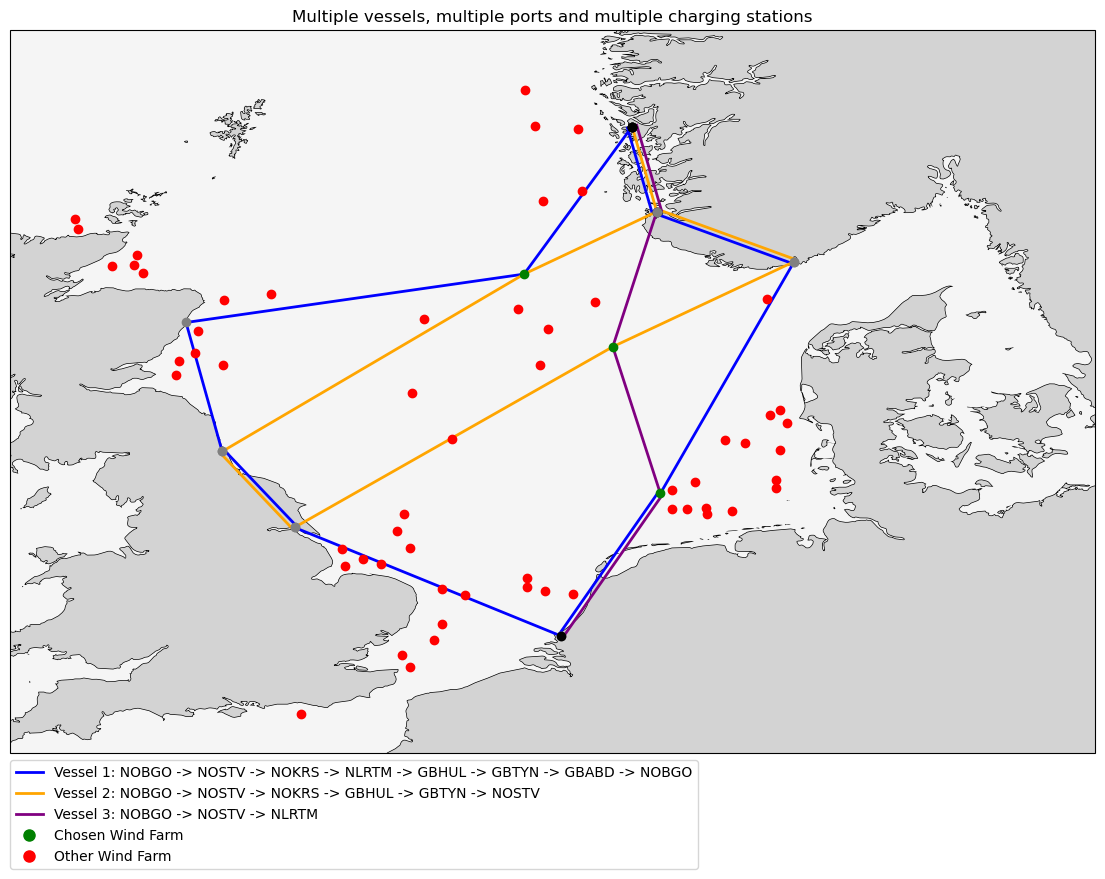


Matplotlib map figure saved as Model_itr4_map_optional.png


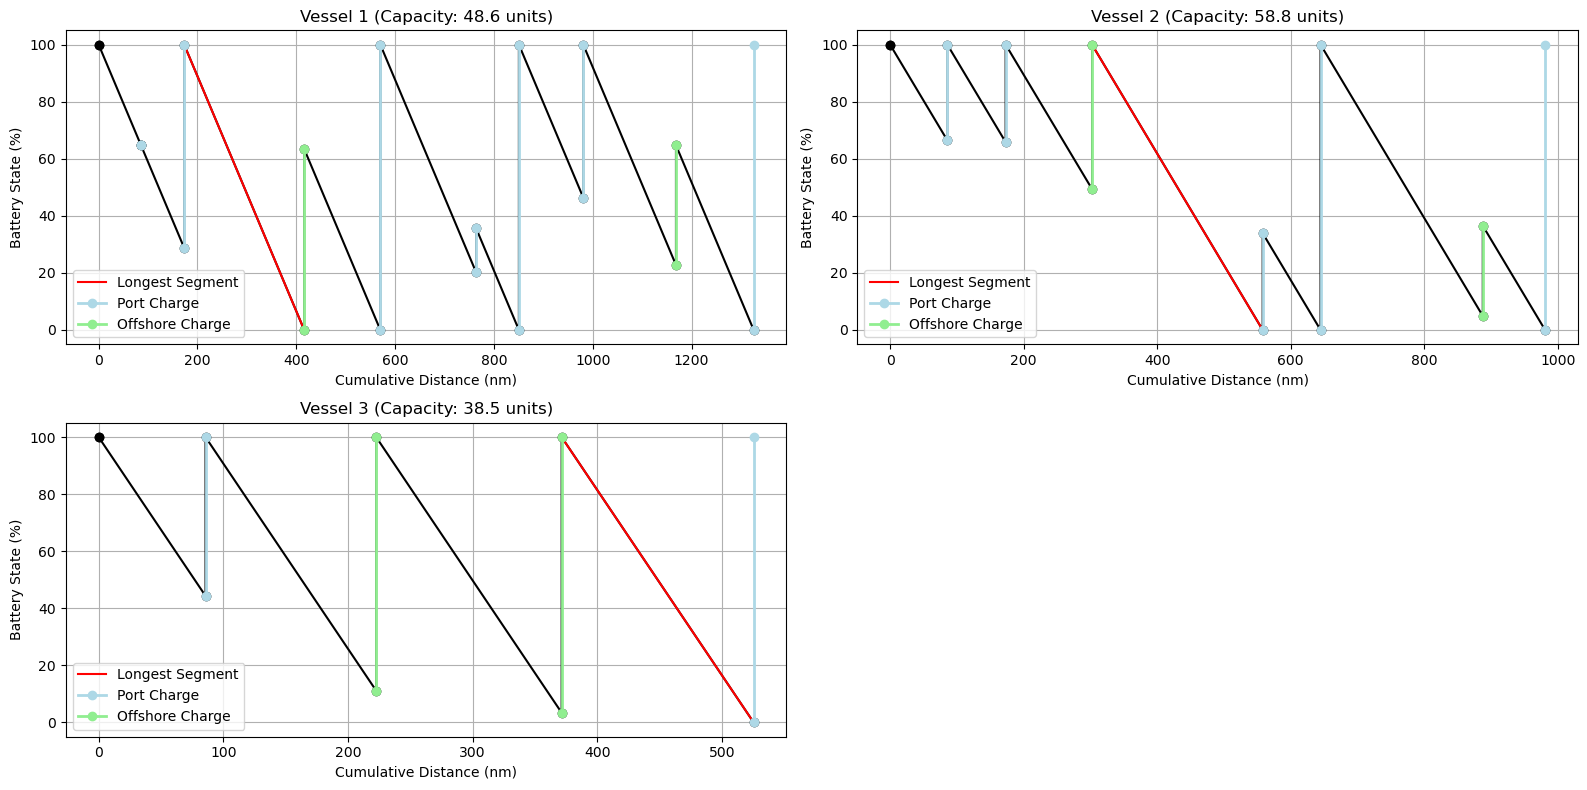


Matplotlib battery state figure saved as Model_itr4_battery_state_optional.png


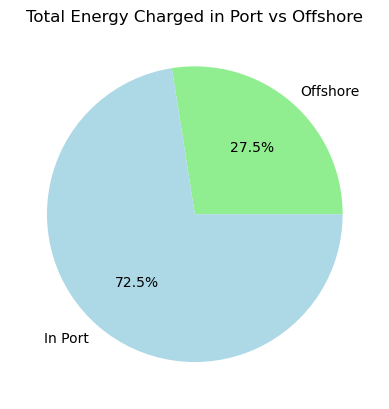


Matplotlib pie figure saved as Model_itr4_battery_state_optional.png


In [14]:
def reconstruct_route(arcs, start, end):
    """
    Reconstruct a route from the list of arcs.
    If start == end (a round-trip), use an outgoing mapping;
    otherwise, sequentially build the route.
    """
    if start == end:
        # Round-trip: build route using outgoing mapping.
        outgoing = {i: j for (i, j) in arcs}
        route = [start]
        next_node = outgoing.get(start)
        while next_node is not None and next_node != start:
            route.append(next_node)
            next_node = outgoing.get(next_node)
        route.append(start)
    else:
        # Non round-trip: follow arcs sequentially.
        route = [start]
        current = start
        visited = {start}
        while current != end:
            found = False
            for (u, k) in arcs:
                if u == current and k not in visited:
                    route.append(k)
                    visited.add(k)
                    current = k
                    found = True
                    break
            if not found:
                print(f"Incomplete route encountered for vessel {v}")
                break
    return route

def physical_key(node_id):
    """
    Generate a physical key for a node based on its ID.
    """
    node = nodes_dict[node_id]
    if node['type'] == 'wind_farm':
        return (node['name'], node['lat'], node['lon'], node['type'])
    else:
        return (node['name'], node['lat'], node['lon'])

def offset_line(lon1, lat1, lon2, lat2, idx, n_lanes, base_offset=0.04):
    """
    Offset a line segment between two points (lon1, lat1) and (lon2, lat2)
    """
    dx = lon2 - lon1
    dy = lat2 - lat1
    length = np.hypot(dx, dy)
    if length == 0:
        return (lon1, lat1), (lon2, lat2)
    nx = -dy / length
    ny = dx / length
    offset_pos = (idx - 1) - (n_lanes - 1) / 2
    offset_dist = offset_pos * base_offset * 2
    offset_lon1 = lon1 + offset_dist * nx
    offset_lat1 = lat1 + offset_dist * ny
    offset_lon2 = lon2 + offset_dist * nx
    offset_lat2 = lat2 + offset_dist * ny
    return (offset_lon1, offset_lat1), (offset_lon2, offset_lat2)

# After verifying that an optimal solution was found.
if model.status == GRB.OPTIMAL:
    # Gather which arcs are used by which vessels using physical keys.
    arc_usage = defaultdict(list)
    for v in V:
        for (i, j) in arcs_used[v]:
            arc_key = (physical_key(i), physical_key(j))
            arc_usage[arc_key].append(v)

    # Plot the Map with Routes
    fig_map = plt.figure(figsize=(14, 10))
    ax_map = plt.axes(projection=ccrs.PlateCarree())
    ax_map.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black')
    ax_map.add_feature(cfeature.OCEAN, facecolor='whitesmoke')
    ax_map.set_extent([-5, 13, 50, 62], crs=ccrs.PlateCarree())

    # Plot all nodes.
    for i in N:
        lat, lon = nodes_dict[i]['lat'], nodes_dict[i]['lon']
        t = nodes_dict[i]['type']
        if t == 'wind_farm' and y[i].X > 0.5:
            color = 'green'  # chosen wind farm
        elif t.startswith('start') or t.startswith('end'):
            color = 'black'
        elif t.startswith('mandatory'):
            color = 'gray'
        else:
            color = 'red'
        ax_map.plot(lon, lat, 'o', color=color, markersize=6,
                    transform=ccrs.PlateCarree(), zorder=5)

    # Build legend for vessels.
    route_colors = ['blue', 'orange', 'purple', 'darkred', 'cadetblue', 'green']
    legend_handles = []
    for idx, v in enumerate(V):
        vessel_color = route_colors[idx % len(route_colors)]
        vessel_label = vessel_info[v-1]['name']
        line = mlines.Line2D([], [], color=vessel_color, linewidth=2, label=vessel_label)
        legend_handles.append(line)
    chosen_marker = mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=8, label='Chosen Wind Farm')
    other_marker  = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=8, label='Other Wind Farm')
    legend_handles.extend([chosen_marker, other_marker])

    # Plot each vessel's route.
    for idx, v in enumerate(V):
        color = route_colors[idx % len(route_colors)]
        arcs_v = arcs_used[v]
        start = vessel_nodes[v]['start']
        end = vessel_nodes[v]['end']
        # Use helper function to get the route list.
        route_list = reconstruct_route(arcs_v, start, end)
        # Plot each leg with an offset if shared by multiple vessels.
        for step in range(len(route_list) - 1):
            p1 = route_list[step]
            p2 = route_list[step + 1]
            lon1, lat1 = nodes_dict[p1]['lon'], nodes_dict[p1]['lat']
            lon2, lat2 = nodes_dict[p2]['lon'], nodes_dict[p2]['lat']
            arc_key = (physical_key(p1), physical_key(p2))
            shared = arc_usage[arc_key]
            shared_sorted = sorted(shared)
            lane_idx = shared_sorted.index(v) + 1
            n_lanes = len(shared)
            (off_lon1, off_lat1), (off_lon2, off_lat2) = offset_line(lon1, lat1, lon2, lat2, lane_idx, n_lanes)
            ax_map.plot([off_lon1, off_lon2], [off_lat1, off_lat2], color=color, linewidth=2,
                        transform=ccrs.PlateCarree(), zorder=3)

    ax_map.set_xlabel('Longitude')
    ax_map.set_ylabel('Latitude')
    ax_map.set_title("Multiple vessels, multiple ports and multiple charging stations")
    ax_map.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(0, -0.01), borderaxespad=0.)
    map_filename = "Model_itr4_map_full.png" if full_charge_mode == 1 else "Model_itr4_map_optional.png"
    fig_map.savefig(map_filename, dpi=150, bbox_inches="tight", pad_inches=0.1)
    plt.show()
    print("\nMatplotlib map figure saved as", map_filename)

# Plot Battery State Profiles for Each Vessel and Pie Chart for Charging Energy
n_vessels = len(V)
ncols = 2
nrows = math.ceil(n_vessels / ncols)
fig_battery, axes = plt.subplots(nrows, ncols, figsize=(16, 4 * nrows), sharex=False)
axes = axes.flatten()  # ensure axes is a 1D array

# Initialize totals for energy charged (assumed in same units as battery[(v, node)].X)
total_offshore_energy = 0.0
total_inport_energy = 0.0

for idx, v in enumerate(V):
    ax = axes[idx]
    arcs_v = arcs_used[v]
    start = vessel_nodes[v]['start']
    end = vessel_nodes[v]['end']
    # Reuse the same route reconstruction function.
    route_list = reconstruct_route(arcs_v, start, end)
    
    # Determine the longest leg along the route.
    max_leg = -1
    max_leg_index = None
    for i in range(len(route_list) - 1):
        leg_dist = D_ij[(route_list[i], route_list[i+1])]
        if leg_dist > max_leg:
            max_leg = leg_dist
            max_leg_index = i

    # Build piecewise data for the battery profile.
    consumption_x, consumption_y = [], []
    consumption_x_max, consumption_y_max = [], []
    vertical_segments = []  # Each as (x, y_start, y_end, color)

    current_dist = 0.0
    start_batt = battery[(v, route_list[0])].X
    prev_percent = (100.0 * start_batt / q_v[v].X) if q_v[v].X > 0 else 0
    prev_dist = current_dist

    for i in range(len(route_list) - 1):
        i_node = route_list[i]
        j_node = route_list[i+1]
        leg_dist = D_ij[(i_node, j_node)]
        current_dist = prev_dist + leg_dist
        
        # Compute battery percentage before any charging at the arrival node.
        arrival_batt = battery[(v, i_node)].X - FC_v[v] * leg_dist
        arrival_percent = (100.0 * arrival_batt / q_v[v].X) if q_v[v].X > 0 else 0

        # Append consumption segment.
        consumption_x.extend([prev_dist, current_dist])
        consumption_y.extend([prev_percent, arrival_percent])
        if i == max_leg_index:
            consumption_x_max.extend([prev_dist, current_dist])
            consumption_y_max.extend([prev_percent, arrival_percent])

        # Compute departure battery level after charging at the node.
        departure_batt = battery[(v, j_node)].X
        departure_percent = (100.0 * departure_batt / q_v[v].X) if q_v[v].X > 0 else 0
        
        # Determine charging type: offshore if node type is wind_farm.
        jump_color = 'lightgreen' if nodes_dict[j_node]['type'] == 'wind_farm' else 'lightblue'
        vertical_segments.append((current_dist, arrival_percent, departure_percent, jump_color))
        
        # Compute the energy charged during this event.
        energy_charged = departure_batt - arrival_batt
        if jump_color == 'lightgreen':
            total_offshore_energy += energy_charged
        else:
            total_inport_energy += energy_charged

        prev_dist = current_dist
        prev_percent = departure_percent

    # Plot the battery consumption segments.
    ax.plot(consumption_x, consumption_y, color='black', marker='o')
    # Highlight the longest leg.
    ax.plot(consumption_x_max, consumption_y_max, color='red', label='Longest Segment')
    ax.plot(0, 100, 'o', color='black')  # starting point

    # Use flags to avoid duplicate legend labels for charging events.
    offshore_plotted = False
    port_plotted = False
    # Plot vertical jumps for charging.
    for (x_val, y_start, y_end, col) in vertical_segments:
        label = None
        if col == 'lightgreen' and not offshore_plotted:
            label = 'Offshore Charge'
            offshore_plotted = True
        elif col == 'lightblue' and not port_plotted:
            label = 'Port Charge'
            port_plotted = True
        ax.plot([x_val, x_val], [y_start, y_end], color=col, marker='o', linewidth=2,
                label=label)
    vessel_name = vessel_info[v - 1]['name']
    installed_cap = q_v[v].X
    ax.set_xlabel("Cumulative Distance (nm)")
    ax.set_ylabel("Battery State (%)")
    ax.set_title(f"Vessel {idx+1} (Capacity: {installed_cap:.1f} units)")
    ax.grid(True)
    ax.legend()
    
for j in range(n_vessels, len(axes)):
    fig_battery.delaxes(axes[j])    

plt.tight_layout()
battery_filename = "Model_itr4_battery_state_full.png" if full_charge_mode == 1 else "Model_itr4_battery_state_optional.png"
fig_battery.savefig(battery_filename, dpi=150, bbox_inches="tight", pad_inches=0.1)
plt.show()
print("\nMatplotlib battery state figure saved as", battery_filename)

# Create a pie chart for total energy charged in port vs offshore.
fig_pie, ax_pie = plt.subplots()
labels = ['Offshore', 'In Port']
sizes = [total_offshore_energy, total_inport_energy]
ax_pie.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['lightgreen', 'lightblue'])
ax_pie.set_title("Total Energy Charged in Port vs Offshore")

pie_filename = "Model_itr4_pie_full.png" if full_charge_mode == 1 else "Model_itr4_pie_optional.png"
fig_pie.savefig(pie_filename, dpi=150, bbox_inches="tight", pad_inches=0.1)
plt.show()
print("\nMatplotlib pie figure saved as", battery_filename)